##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Setup

In [1]:
%pip install -qU 'google-genai'

Note: you may need to restart the kernel to use updated packages.


## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [3]:
from google import genai
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

## Download and inspect the PDF

Install the PDF processing tools. You don't need these to use the API, it's just used to display a screenshot of a page.

In [4]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (359 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126210 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


This PDF page is an article titled [Smoothly editing material properties of objects with text-to-image models and synthetic data](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) available on the Google Research Blog.

In [3]:
import pathlib

if not pathlib.Path('test.pdf').exists():
  !curl -o test.pdf https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6538k  100 6538k    0     0   9.7M      0 --:--:-- --:--:-- --:--:--  9.7M


Look at one of the pages:

In [7]:
!pdftoppm test.pdf -f 1 -l 1 page-image -jpeg
!ls *jpg

page-image-1.jpg


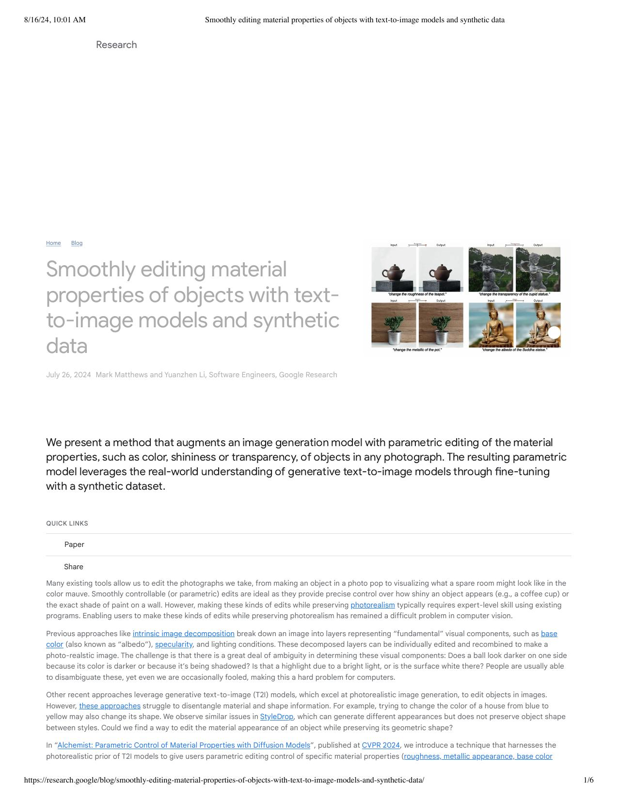

In [8]:
import PIL.Image

img = PIL.Image.open(f"page-image-1.jpg")
img.thumbnail([800, 800])
img

## Upload the file to the API

In [9]:
file_ref = client.files.upload(file='test.pdf')

## Try it out

In [10]:
MODEL_ID="gemini-2.5-flash-preview-04-17" # @param ["gemini-2.5-flash-preview-04-17", "gemini-2.5-pro-preview-03-25", "gemini-2.0-flash", "gemini-2.0-flash-lite"] {"allow-input":true, isTemplate: true}

The pages of the PDF file are each passed to the model as a screenshot of the page plus the text extracted by OCR.

In [11]:
client.models.count_tokens(
    model=MODEL_ID,
    contents=[file_ref, 'Summarize this file as a bulleted list']
).total_tokens

1558

In [12]:
response = client.models.generate_content(
    model = MODEL_ID,
    contents = [file_ref, 'Summarize this file as a bulleted list']
)

In [13]:
from IPython.display import Markdown
Markdown(response.text)

Here is a summary of the provided text as a bulleted list:

*   Editing material properties like color, shininess, or transparency in photographs while preserving photorealism is difficult with existing tools, often requiring expert skills.
*   Previous computer vision methods like intrinsic image decomposition struggle with the inherent ambiguity of separating components like color, specularity, and lighting.
*   Recent approaches using text-to-image (T2I) models face challenges in disentangling material and shape edits.
*   The presented method, called "Alchemist," addresses this by augmenting a generative T2I model (fine-tuned Stable Diffusion 1.5) with parametric control over material properties.
*   The key to the method is fine-tuning the model on a specially created synthetic dataset.
*   This dataset consists of renderings of 100 3D household objects, showing variations in a single material attribute (roughness, metallic, albedo, transparency) with different "edit strengths" (scalar values), while keeping object shape, lighting, and camera angle constant.
*   The modified T2I model accepts the context image, an edit instruction (e.g., "change the metallic"), and the scalar edit strength as input.
*   The fine-tuned model successfully generalizes from the synthetic data to real-world images, allowing users to smoothly change specific material properties parametrically.
*   The method effectively preserves the object's shape and the original image's lighting conditions during edits.
*   Examples show realistic edits like making objects metallic or transparent, including effects like caustics for transparent objects.
*   A user study found the method produced more photorealistic edits (69.6%) and was strongly preferred (70.2%) compared to a baseline (InstructPix2Pix) trained on the same synthetic data.
*   Potential applications include easily visualizing interior design changes, creating product design mock-ups, and enabling 3D consistent material edits for downstream tasks like NeRF reconstruction.
*   The research is detailed in the paper "Alchemist: Parametric Control of Material Properties with Diffusion Models," presented at CVPR 2024.

In addition, take a look at how the Gemini model responds when you ask questions about the images within the PDF.

In [14]:
response_2 = client.models.generate_content(
    model = MODEL_ID,
    contents = [file_ref, 'Explain the images on the first page of the document']
)

In [15]:
from IPython.display import Markdown
Markdown(response_2.text)

Based on the OCR text of the first page, the main visual content is a set of four pairs of images, each demonstrating the method described in the article.

Here's a breakdown of the images on the first page:

1.  **Layout:** The images are presented in a grid format, with each example showing an "Input" image and a corresponding "Output" image side-by-side. Below each pair is the text instruction used to generate the output.

2.  **Purpose:** These image pairs serve as visual examples of the paper's core contribution: using text instructions to smoothly edit the material properties of objects within an image, while keeping the object's shape and other scene attributes consistent.

3.  **Specific Examples Shown:**
    *   **Teapot:**
        *   **Instruction:** "change the roughness of the teapot."
        *   **Images:** Shows an original teapot (Input) and the same teapot with its roughness modified (Output), presumably making it smoother or shinier based on the visual change implied by "roughness" editing.
    *   **Cupid Statue:**
        *   **Instruction:** "change the transparency of the cupid statue."
        *   **Images:** Shows an original opaque statue (Input) and the same statue made partially or fully transparent (Output), allowing the background to be seen through it.
    *   **Pot:**
        *   **Instruction:** "change the metallic of the pot."
        *   **Images:** Shows an original pot (Input) and the same pot with a metallic appearance added (Output), likely showing reflections characteristic of metal.
    *   **Buddha Statue:**
        *   **Instruction:** "change the albedo of the Buddha statue."
        *   **Images:** Shows an original Buddha statue (Input) and the same statue with its base color (albedo) changed (Output), likely to a different color as specified by the underlying control mechanism tied to the instruction.

In essence, these images visually illustrate the power of the described method to perform targeted, semantic edits to material properties like roughness, transparency, metallicity, and albedo using simple text prompts, maintaining the overall photorealism and geometry of the original image.

If you observe the area of the header of the article, you can see that the model captures what is happening.

## Learning more

The File API lets you upload a variety of multimodal MIME types, including images, audio, and video formats. The File API handles inputs that can be used to generate content with `model.generateContent` or `model.streamGenerateContent`.

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

* Learn more about prompting with [media files](https://ai.google.dev/gemini-api/docs/file-prompting-strategies) in the docs, including the supported formats and maximum length.
* Learn more about to extract structured outputs from PDFs in the [Structured outputs on invoices and forms](https://github.com/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) example.
